## test

In [ ]:
import numpy as np
try:
    from matplotrender.src.matplotrender import *
except:
    #!pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

# import meshplot as mp
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple


In [ ]:
def batched_trilinear_weights(points, cube_bounds_min, cube_bounds_max, eps=1e-8):
    """
    Vectorized version of get_trilinear_weights_torch for:
        points:       (B, N, 3)
        cube_bounds_min: (B, M, 3)
        cube_bounds_max: (B, M, 3)

    Returns:
        mask_inside: (B, N, M) whether point i is inside cube j
        weights:     (B, N, M, 8) trilinear weights
    """
    B, N, _ = points.shape
    M = cube_bounds_min.shape[1]

    # Expand dimensions for broadcasting
    points_exp = points[:, :, None, :]       # (B, N, 1, 3)
    cube_min = cube_bounds_min[:, None, :, :]  # (B, 1, M, 3)
    cube_max = cube_bounds_max[:, None, :, :]  # (B, 1, M, 3)

    # (B, N, M, 3)
    inside = (points_exp >= cube_min - eps) & (points_exp <= cube_max + eps)
    mask_inside = inside.all(dim=-1)  # (B, N, M)

    denom = cube_max - cube_min + eps  # (B, 1, M, 3)
    local = (points_exp - cube_min) / denom  # (B, N, M, 3)

    x, y, z = local[..., 0], local[..., 1], local[..., 2]  # (B, N, M)

    # Compute trilinear weights
    w000 = (1 - x) * (1 - y) * (1 - z)
    w001 = (1 - x) * (1 - y) * z
    w010 = (1 - x) * y * (1 - z)
    w011 = (1 - x) * y * z
    w100 = x * (1 - y) * (1 - z)
    w101 = x * (1 - y) * z
    w110 = x * y * (1 - z)
    w111 = x * y * z

    weights = torch.stack([w000, w001, w010, w011, w100, w101, w110, w111], dim=-1)  # (B, N, M, 8)

    # Zero out weights where outside
    weights = weights * mask_inside[..., None]  # (B, N, M, 8)

    return mask_inside, weights


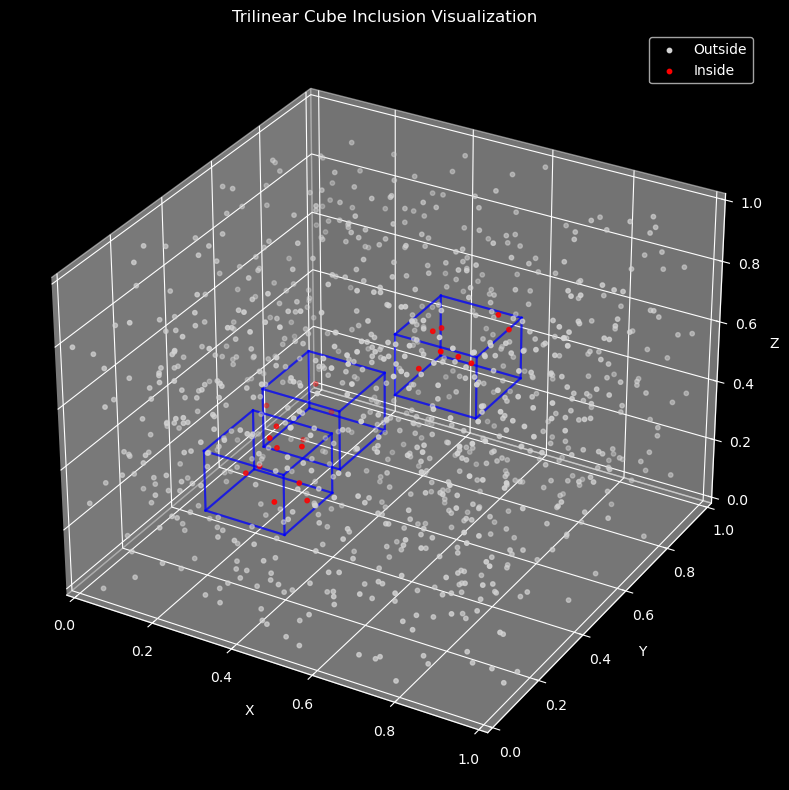

In [ ]:

# Generate synthetic data
B, N, M = 1, 1000, 3
points = torch.rand(B, N, 3)
cube_min = torch.tensor([
    [[0.2, 0.2, 0.2],
     [0.5, 0.5, 0.5],
     [0.1, 0.6, 0.1]]
])
cube_max = cube_min + 0.2

# Compute trilinear weights and inside mask

mask, _ = batched_trilinear_weights(points, cube_min, cube_max)

# Extract inside/outside points
mask_any_cube = mask.any(dim=-1)[0]  # (N,)
inside_pts = points[0][mask_any_cube]
outside_pts = points[0][~mask_any_cube]

# Visualize
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(*outside_pts.T, c='lightgray', s=10, label='Outside')
ax.scatter(*inside_pts.T, c='red', s=10, label='Inside')

# Plot cube outlines
for i in range(M):
    cmin = cube_min[0, i].numpy()
    cmax = cube_max[0, i].numpy()
    for dx in [0, 1]:
        for dy in [0, 1]:
            for dz in [0, 1]:
                start = cmin + [dx * (cmax[0]-cmin[0]), dy * (cmax[1]-cmin[1]), dz * (cmax[2]-cmin[2])]
                for axis in range(3):
                    end = start.copy()
                    end[axis] = cmax[axis] if start[axis] == cmin[axis] else cmin[axis]
                    ax.plot(*zip(start, end), c='blue', alpha=0.5)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trilinear Cube Inclusion Visualization')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
def check_rotated_cube_trilinear(points, cube_centers, cube_rotations, cube_scales, eps=1e-8):
    """
    Args
      points:         (B, N, 3) world-space points
      cube_centers:   (B, M, 3)
      cube_rotations: (B, M, 3, 3) rotation matrices (world->local)
      cube_scales:    (B, M, 3) side lengths along local axes
    Returns
      mask_inside: (B, N, M) point-in-cube mask
      weights:     (B, N, M, 8) trilinear weights (masked to 0 if outside)
    """
    B, N, _ = points.shape
    M = cube_centers.shape[1]

    pts     = points[:, :, None, :]          # (B, N, 1, 3)
    centers = cube_centers[:, None, :, :]    # (B, 1, M, 3)
    R       = cube_rotations                 # (B, M, 3, 3)
    scales  = cube_scales[:, None, :, :]     # (B, 1, M, 3)

    # world -> local
    rel = pts - centers                      # (B, N, M, 3)
    # rel_local[b,n,m,:] = R[b,m,:,:]^T @ rel[b,n,m,:]
    rel_local = torch.einsum('bnmk,bmlk->bnml', rel, R)  # (B, N, M, 3)

    # inside test
    half = 0.5 * scales
    inside = (rel_local >= -half - eps) & (rel_local <= half + eps)
    mask_inside = inside.all(dim=-1)  # (B, N, M)

    # local -> [0,1] normalized coords
    normed = (rel_local + half) / (scales + eps)  # (B, N, M, 3)
    x, y, z = normed.unbind(-1)

    # trilinear (barycentric-like) weights
    w000 = (1 - x) * (1 - y) * (1 - z)
    w001 = (1 - x) * (1 - y) * z
    w010 = (1 - x) * y * (1 - z)
    w011 = (1 - x) * y * z
    w100 = x * (1 - y) * (1 - z)
    w101 = x * (1 - y) * z
    w110 = x * y * (1 - z)
    w111 = x * y * z

    weights = torch.stack([w000, w001, w010, w011, w100, w101, w110, w111], dim=-1)  # (B,N,M,8)
    weights = weights * mask_inside[..., None]  # zero out if outside
    return mask_inside, weights

def cube_corners_from_center_R_scale(center, R, scale):
    """Return 8 corners of a rotated box in a fixed order."""
    half = 0.5 * scale
    axes = R @ torch.diag(half)  # columns: world-space half-axes
    signs = torch.tensor(
        [[-1,-1,-1],[ 1,-1,-1],[-1, 1,-1],[ 1, 1,-1],
         [-1,-1, 1],[ 1,-1, 1],[-1, 1, 1],[ 1, 1, 1]],
        dtype=center.dtype, device=center.device
    )  # (8,3)
    return center[None,:] + signs @ axes.T  # (8,3)

def plot_rotated_cubes_and_points(points, cube_centers, cube_rotations, cube_scales, mask_inside):
    """3D scatter of inside/outside points + rotated cube edges for batch 0."""
    b = 0
    pts = points[b].cpu().numpy()
    inside_any = mask_inside[b].any(dim=-1).cpu().numpy()

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    pts_out = pts[~inside_any]
    pts_in  = pts[inside_any]
    if pts_out.size > 0:
        ax.scatter(pts_out[:,0], pts_out[:,1], pts_out[:,2], marker='.', alpha=0.3, label='Outside')
    if pts_in.size > 0:
        ax.scatter(pts_in[:,0], pts_in[:,1], pts_in[:,2], marker='x', alpha=0.9, label='Inside')

    edges = [(0,1),(0,2),(0,4),(1,3),(1,5),(2,3),(2,6),(3,7),(4,5),(4,6),(5,7),(6,7)]
    M = cube_centers.shape[1]
    for m in range(M):
        c = cube_centers[b, m]
        R = cube_rotations[b, m]
        s = cube_scales[b, m]
        corners = cube_corners_from_center_R_scale(c, R, s).cpu().numpy()
        for i,j in edges:
            p, q = corners[i], corners[j]
            ax.plot([p[0], q[0]],[p[1], q[1]],[p[2], q[2]], alpha=0.7)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('Rotated Cubes: Inclusion + Trilinear Regions (Batch 0)')
    ax.legend(loc='upper right')
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    plt.show()


torch.Size([1, 2500, 4, 8])
Mean(sum of weights) over valid pairs: 1.0


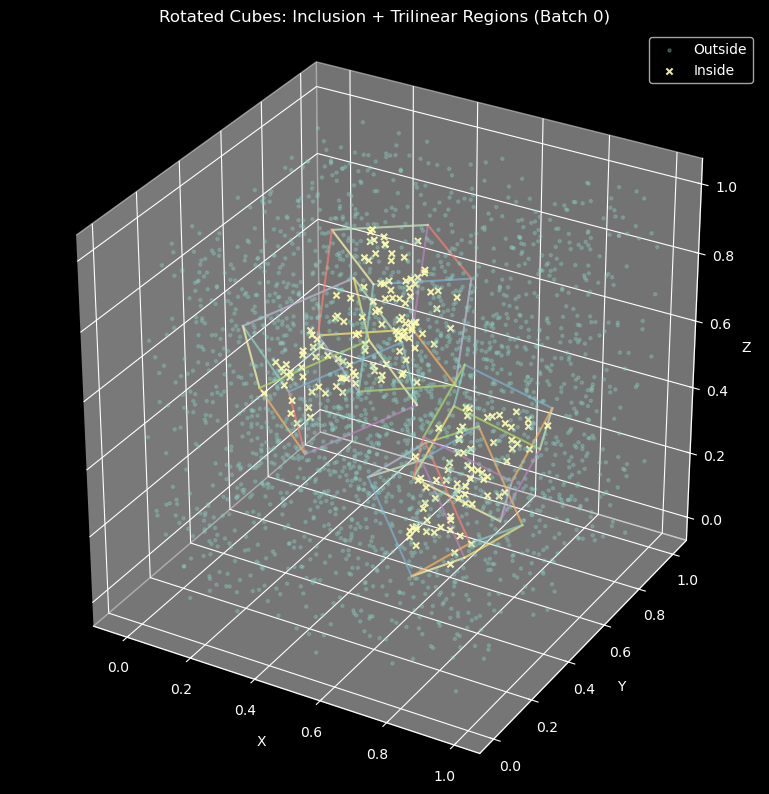

In [ ]:
torch.manual_seed(1)


B, N, M = 1, 2500, 4
points = torch.rand(B, N, 3)                       # random query points in [0,1]^3
cube_centers = 0.2 + 0.6 * torch.rand(B, M, 3)     # centers
cube_scales  = 0.2 + 0.15 * torch.rand(B, M, 3)    # side lengths (each axis)
R = torch.randn(B, M, 3, 3)
U, _, Vh = torch.linalg.svd(R)
cube_rotations = U @ Vh.transpose(-1, -2)          # orthonormal rotations

mask_inside, weights = check_rotated_cube_trilinear(points, cube_centers, cube_rotations, cube_scales)
print(weights.shape)


# Sanity: over valid (point,cube) pairs, weight sums should be ~1
pair_sums = weights.sum(dim=-1)[mask_inside]
if pair_sums.numel() > 0:
    print("Mean(sum of weights) over valid pairs:", float(pair_sums.mean()))

# Visualize batch 0
plot_rotated_cubes_and_points(points, cube_centers, cube_rotations, cube_scales, mask_inside)